# Oxford Pets Image Retrieval Exploration

This is an image retrieval system Jupyter Notebook that explores using Scale-Invariant Feature Transform (SIFT) and Convolutional Neural Networks (CNNs) to return images from a database based on a query image.

# Setting up the libraries and environment

In [ ]:
!pip install torch torchvision matplotlib opencv-python pandas

In [ ]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import copy
from collections import defaultdict
from getpass import getpass
import time
from sklearn.metrics import precision_recall_curve

100%|██████████| 792M/792M [00:55<00:00, 14.2MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 10.6MB/s]


(<PIL.Image.Image image mode=RGB size=394x500 at 0x7BA3BF3D1190>, 0)


Dimension of image: torch.Size([3680, 3, 224, 224]) 
Dimension of labels torch.Size([3680])


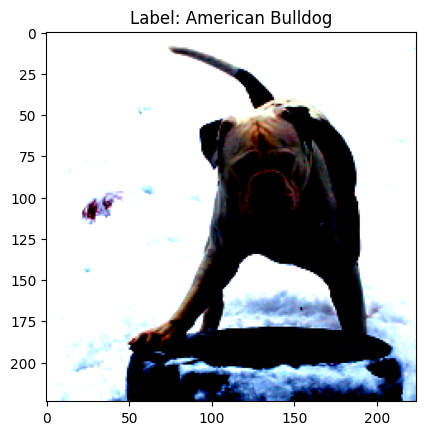

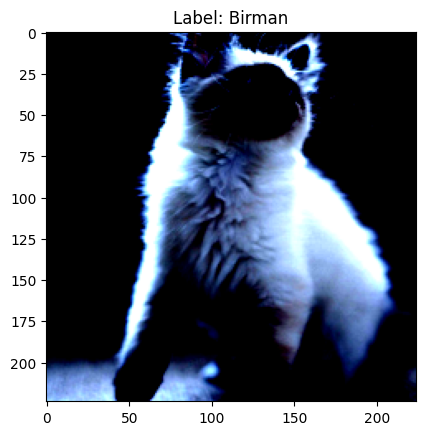

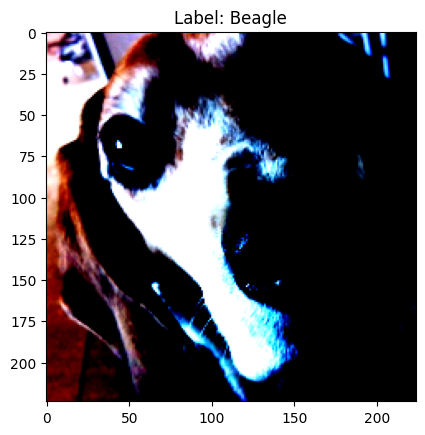

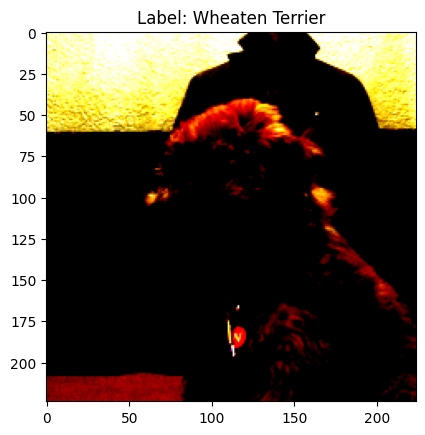

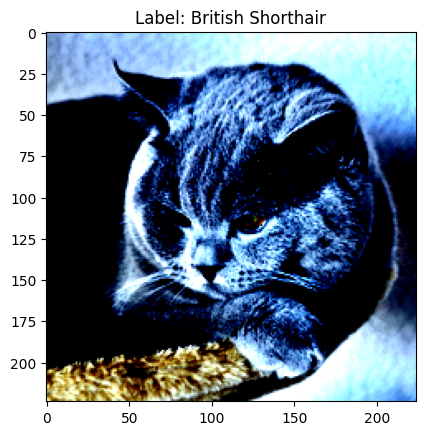

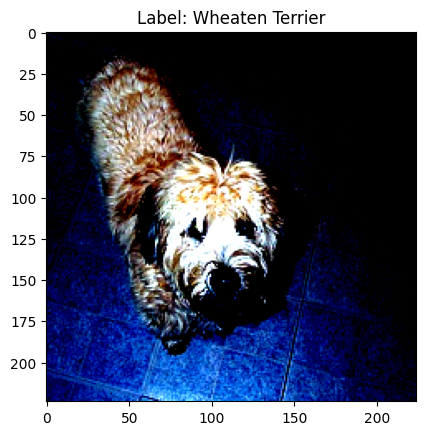

In [ ]:
# Load the Oxford Pets dataset
train_dataset = torchvision.datasets.OxfordIIITPet("./data", split="trainval", download=True)
test_dataset = torchvision.datasets.OxfordIIITPet("./data", split="test", download=True)

print(train_dataset[0])

# Preprocess the dataset for VGG and store separately
vgg_preprocess = models.VGG16_Weights.DEFAULT.transforms()

train_vgg = torchvision.datasets.OxfordIIITPet("./data", split="trainval", transform=vgg_preprocess, download=True)
test_vgg = torchvision.datasets.OxfordIIITPet("./data", split="test", transform=vgg_preprocess, download=True)

train_vgg_loader = torch.utils.data.DataLoader(train_vgg, batch_size=len(train_vgg), shuffle=False)
x_VGG, y_VGG = next(iter(train_vgg_loader))

test_vgg_loader = torch.utils.data.DataLoader(test_vgg, batch_size=len(test_vgg), shuffle=False)
x_test_VGG, y_test_VGG = next(iter(test_vgg_loader))

# Display dataset metadata
dim = x_VGG.shape[0]
print("Dimension of image:", x_VGG.shape, "\nDimension of labels", y_VGG.shape)

# Show 6 random data points (images)
for _ in range(6):
  index = np.random.choice(dim, replace=False)
  plt.imshow(x_VGG[index].permute(1, 2, 0).numpy())
  plt.title(f"Label: {train_dataset.classes[y_VGG[index]]}")
  plt.show()

# Feature Extraction

Example keypoints:


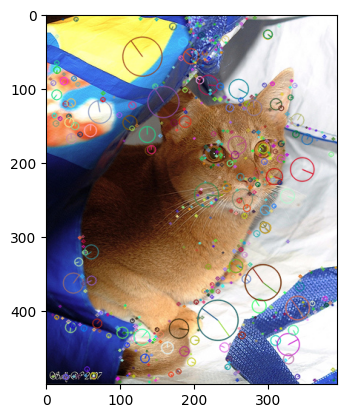

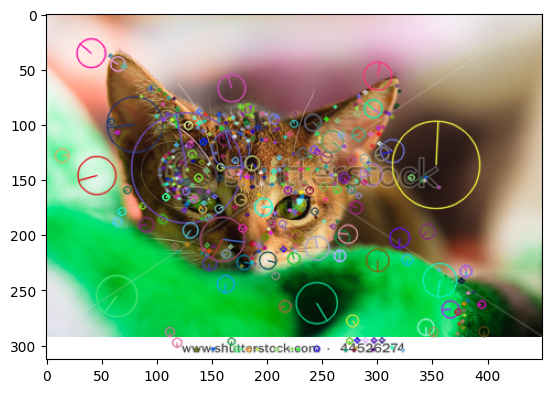

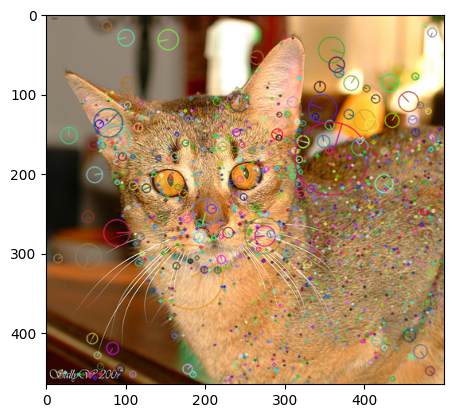

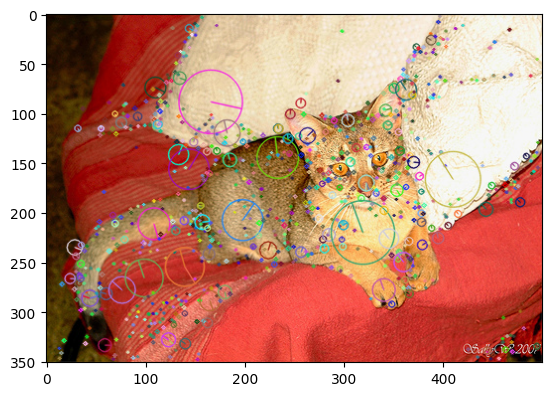

In [ ]:
# Sift extraction (Ref: https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html)
sift = cv2.SIFT_create()

# Gets the sift features for an image
def get_sift_features(image):
  np_img = np.array(image)
  img_grey = cv2.cvtColor(np_img, cv2.COLOR_BGR2GRAY)
  keypoints, descriptors = sift.detectAndCompute(img_grey, None)

  return keypoints, descriptors

# Draws the keypoints on an image
def draw_sift(image, keypoints):
  np_img = np.array(image)
  img_grey = cv2.cvtColor(np_img, cv2.COLOR_BGR2GRAY)
  draw_this = cv2.drawKeypoints(np_img, keypoints, img_grey, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  plt.imshow(draw_this)
  plt.show()

# Get all features for the training dataset
sift_features = [get_sift_features(datum[0]) for datum in train_dataset]

# Draw example images and keypoints
print("Example keypoints:")
for i in range(4):
  draw_sift(train_dataset[i][0], sift_features[i][0])


In [ ]:
# CNN feature extraction
# Main reference: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html

vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
vgg16.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

conv_output = []
fc_output = []

# Prints index and layer, to see where to add hooks
print("VGG16 Convolutional Layers:")
for i, layer in enumerate(vgg16.features):
  print(f"{i}: {layer}")

print("\nVGG16 Fully Connected Layers:")
for i, layer in enumerate(vgg16.classifier):
  print(f"{i}: {layer}")

# Create a submodel for just the convolutional layer output,
# found layer using above prints
conv5_3_model = torch.nn.Sequential(*list(vgg16.features.children())[:30]).to(device)

# Test the whole CNN on 5 sample images:
index = torch.randperm(x_VGG.size(0))[:5]
sample_x_VGG = x_VGG[index].to(device)

with torch.no_grad():
  fc_output = vgg16(sample_x_VGG)
  conv_output = conv5_3_model(sample_x_VGG)

print("Convolutional Layer Output Size:", conv_output.shape)
print("Fully Connected Layer Output Size:", fc_output.shape)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:28<00:00, 19.7MB/s]


VGG16 Convolutional Layers:
0: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1: ReLU(inplace=True)
2: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3: ReLU(inplace=True)
4: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6: ReLU(inplace=True)
7: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8: ReLU(inplace=True)
9: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11: ReLU(inplace=True)
12: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13: ReLU(inplace=True)
14: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15: ReLU(inplace=True)
16: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
17: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
18: ReLU(inpla

# Similarity Measures


Query Image:


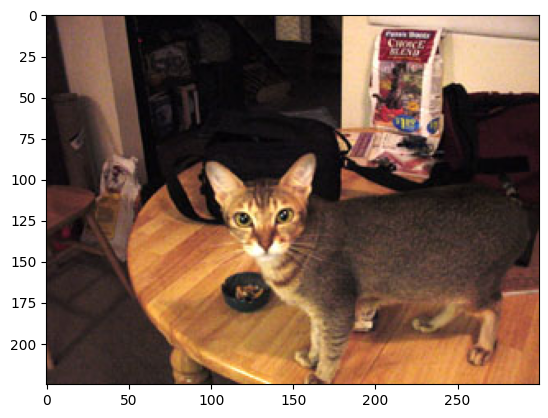


Cosine Similarity Results:


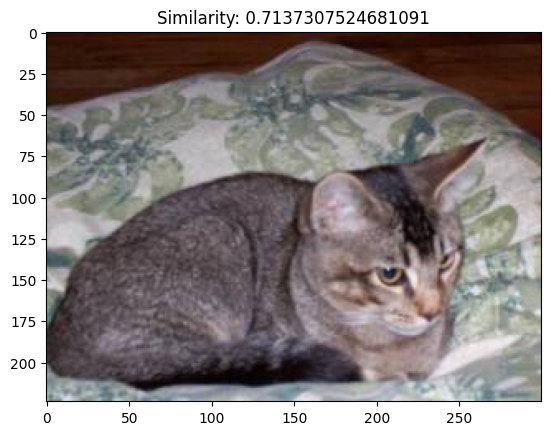

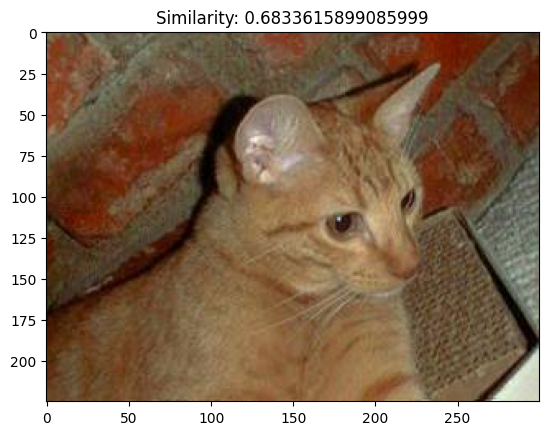

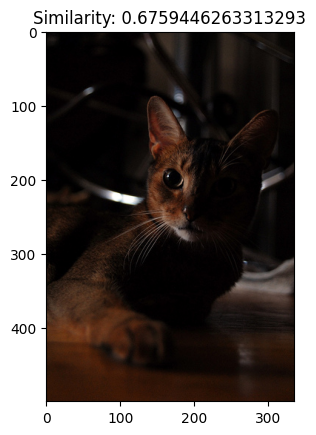

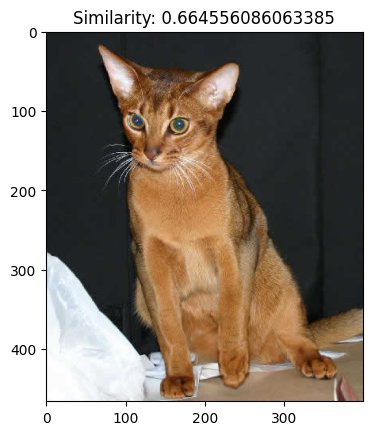

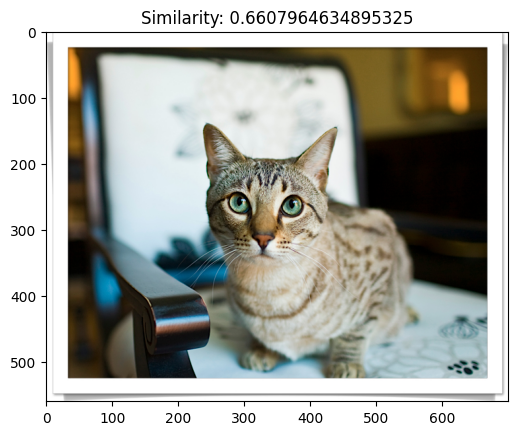


Euclidean Distance Results:


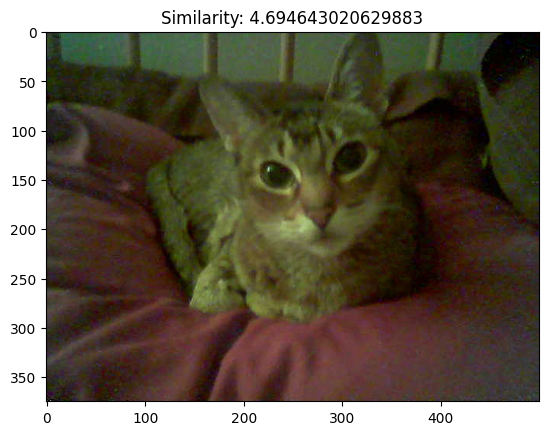

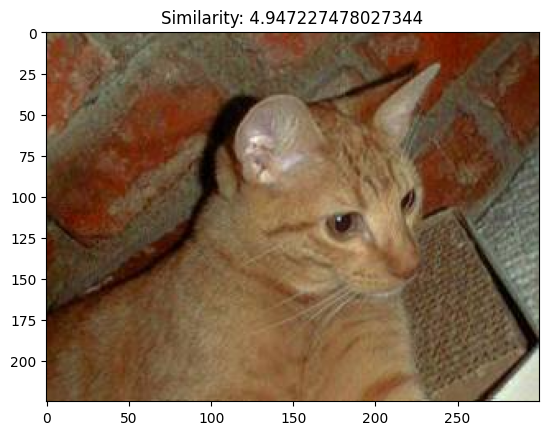

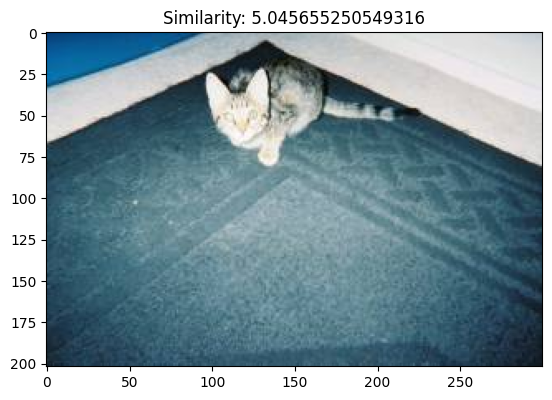

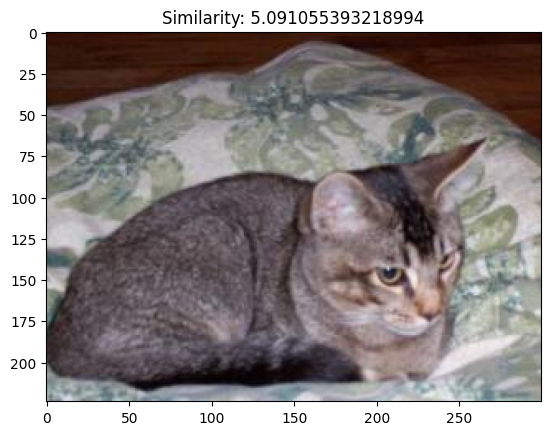

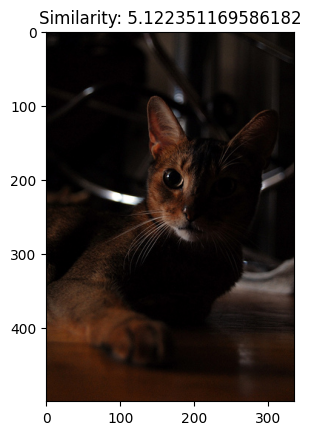

In [ ]:
# Cosine similarity and Euclidean distance from scratch:
def cosine_similarity(a, b):
  norm_A = np.sqrt(np.sum(a**2))
  norm_B = np.sqrt(np.sum(b**2))
  return (a @ b) / (norm_A * norm_B)

def euclidean_distance(a, b):
  return np.sqrt(np.sum((a - b)**2))

# Get some sample images from the dataset (512)
# and average pool them for vector comparison
sim_index = torch.randperm(x_VGG.size(0))[:512]
output = []
loader = torch.utils.data.DataLoader(x_VGG[sim_index], batch_size=32)

features = []
with torch.no_grad():
    for batch in loader:
        batch = batch.to(device)
        out = conv5_3_model(batch)
        pooled = torch.mean(out, dim=(2, 3))
        features.append(pooled.cpu())

sim_VGG_features = torch.cat(features, dim=0).numpy()

# Checks a query image against the above VGG features
# and return sorted DF of best results
def query_image_basic(query_image):
  query_vec = []
  with torch.no_grad():
    query_vec = conv5_3_model(query_image.to(device))
    query_vec = torch.mean(query_vec, dim=(1, 2)).cpu().numpy()
  similarity_tuples = [(cosine_similarity(query_vec, image), euclidean_distance(query_vec, image)) for image in sim_VGG_features]
  sim_df = pd.DataFrame(similarity_tuples, index=sim_index.tolist(), columns=["cosine", "euclidean"])

  return sim_df.sort_values(by="cosine", ascending=False)

# Display the top k images given a query and a measure
def show_top_k_images(query_image, k, measure = "cosine"):
  df = query_image_basic(query_image)
  df = df.sort_values(by=measure, ascending=(measure == "euclidean"))
  indexes = df.head(k).index.to_numpy()
  for i in indexes:
    plt.imshow(train_dataset[i][0])
    plt.title(f"Similarity: {df.loc[i, measure]}")
    plt.show()

# Print the query and results
query_index = 0
print("Query Image:")
plt.imshow(np.array(test_dataset[query_index][0]))
plt.show()

print("\nCosine Similarity Results:")
show_top_k_images(x_test_VGG[query_index], 5, "cosine")

print("\nEuclidean Distance Results:")
show_top_k_images(x_test_VGG[query_index], 5, "euclidean")


# Image Retrieval Pipeline


In [ ]:
import numpy as np
import cv2
from sklearn.cluster import KMeans

def extract_sift_features(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Create a SIFT feature extractor
    sift = cv2.SIFT_create()

    # Detect and compute SIFT features
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    # print("keypoint :",keypoints)
    # print("descriptors :",descriptors)

    return descriptors

def cluster_features(features, k):
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)

    # Get the cluster centers (visual words)
    visual_words = kmeans.cluster_centers_

    return visual_words, kmeans

# Get all the sift features for the dataset images
pipeline_features = [extract_sift_features(np.array(datum[0])) for datum in train_dataset]

# Flatten the array
all_descriptors = np.vstack(pipeline_features)

# Use a large sample of the descriptors to create clusters
# (cannot use all or will hit RAM limits)
def sample_descriptors(descriptors, max_descriptors=500000):
  index = np.random.choice(len(descriptors), min(max_descriptors, len(descriptors)), replace=False)
  return descriptors[index]

# Get kmeans object for clustering descriptors with visual words
sampled_descriptors = sample_descriptors(all_descriptors)
_, kmeans = cluster_features(sampled_descriptors, 100)

# For one single image's descriptors ie. [discriptors here]
def assign_vis_words_one(descriptors, kmeans):
  return kmeans.predict(descriptors)

# For many image's descriptors ie. [[image 1 descriptors], [image 2 descriptors]]
def assign_vis_words_many(image_descriptors, kmeans):
  doc_term_matrix = {}

  for i, descriptors in enumerate(image_descriptors):
    if len(descriptors) > 0:
      words = assign_vis_words_one(descriptors, kmeans)
      doc_term_matrix[i] = words
    else:
      doc_term_matrix[i] = []

  return doc_term_matrix

doc_term_matrix = assign_vis_words_many(pipeline_features, kmeans)


Query Image:


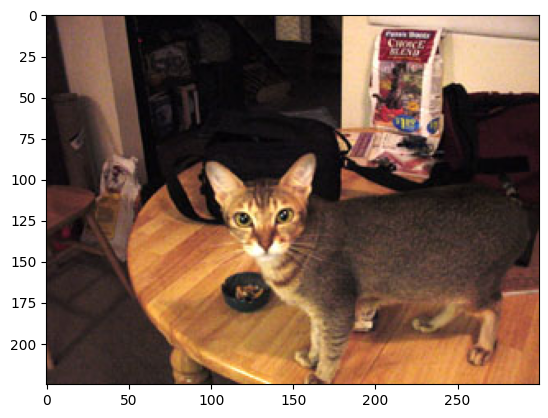


Top-K results, sorted by shared word frequency


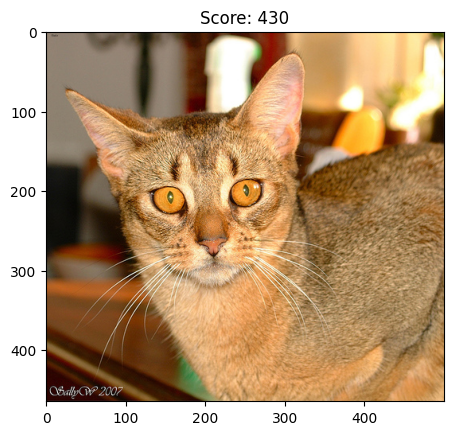

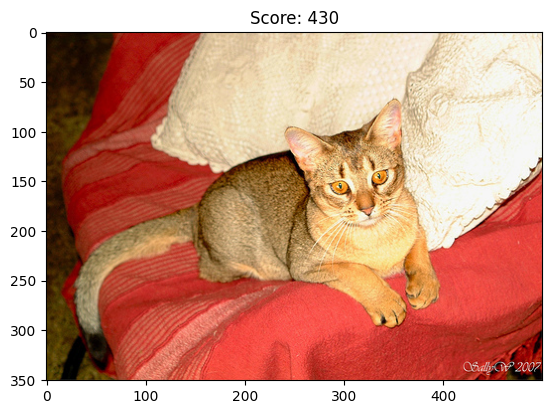

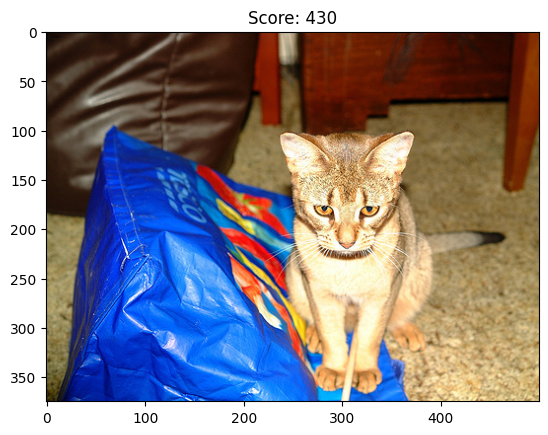

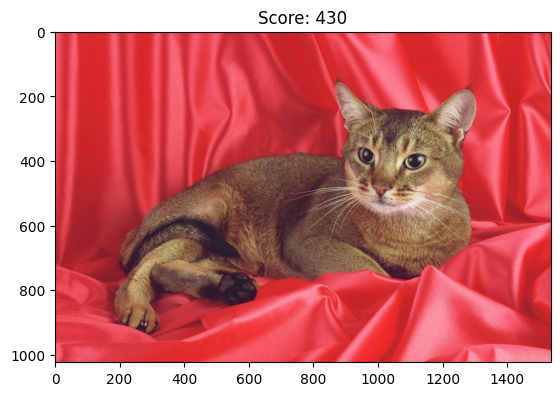

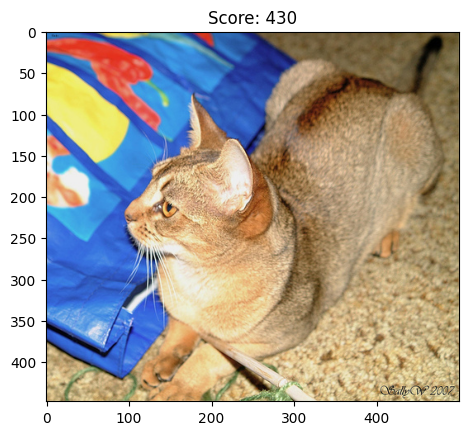

In [ ]:
query_image = test_dataset[query_index][0]

# Extract the query visual words using query image
def extract_query_words(query_image):
  query_np = np.array(query_image)
  query_feats = extract_sift_features(query_np)

  query_words = assign_vis_words_one(query_feats, kmeans)
  return query_words

# Build the inverted index using the document (image) term (visual word) matrix
def build_inverted_index(doc_term_matrix):
  inverted_index = defaultdict(set)

  for img_id, word_ids in doc_term_matrix.items():
    for word_id in set(word_ids):
      inverted_index[word_id].add(img_id)

  return dict(inverted_index)

inverted_index = build_inverted_index(doc_term_matrix)

# Display the top k inverted index results given a query image
def display_top_k_inv_ind(query_image, inverted_index, k):
  query_words = extract_query_words(query_image)

  scores = defaultdict(int)
  for word in query_words:
    for image_id in inverted_index[word]:
      scores[image_id] += 1

  # Sorted by score in descending order
  ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)

  for i, score in ranked[:k]:
    plt.imshow(np.array(train_dataset[i][0]))
    plt.title(f"Score: {score}")
    plt.show()


# Print results
print("Query Image:")
plt.imshow(query_image)
plt.show()

print("\nTop-K results, sorted by shared word frequency")
display_top_k_inv_ind(query_image, inverted_index, 5)
